# Assignment: Unsupervised Machine Learning for Customer Segmentation and Recommendation Systems

## Introduction
The aim of this assignment is to apply **unsupervised machine learning techniques** to real-world e-commerce data. Specifically, the project explores three business-critical problems:  
1. **Customer segmentation** – grouping customers based on purchasing behavior.  
2. **Product recommendation** – identifying products to suggest for cross-selling.  
3. **Purchase prediction** – forecasting future purchases based on historical trends.  

---

## Dataset Description
- **Dataset**: UCI Online Retail Dataset  
- **Source**: https://archive.ics.uci.edu/dataset/352/online+retail
- **Business Context**: Transactions from a UK-based online retailer specializing in gifts, with both individual and wholesale customers.  
- **Timeframe**: December 2010 – December 2011  
- **Size**: 541,909 transactions, 8 attributes  


---

## Problem Rephrase  

E-commerce businesses today face a fundamental challenge in transforming vast amounts of transaction data into actionable customer insights. Despite having access to detailed purchase histories, browsing patterns, and customer interactions, companies struggle with three critical areas: identifying meaningful customer segments for targeted marketing, delivering personalized product recommendations that drive cross-sell opportunities, and accurately predicting future purchase behavior for inventory and campaign planning. These challenges are compounded by data sparsity, diverse customer preferences, and complex temporal patterns that make traditional analytical approaches insufficient.

The consequences of these limitations are significant and directly impact business performance. Without effective customer segmentation, companies resort to generic marketing campaigns that yield poor engagement rates and waste advertising budgets. Inadequate recommendation systems result in missed revenue opportunities and reduced customer satisfaction, while poor purchase prediction capabilities lead to inventory mismatches, ineffective marketing timing, and the inability to proactively retain at-risk customers. This creates a cycle where businesses cannot optimize customer lifetime value or implement data-driven strategies that would otherwise drive sustainable growth and competitive advantage in the crowded e-commerce marketplace.

---

## Why I Choose this Dataset

This is a real-world dataset, not toy data, which means it comes with imperfections and challenges. It provides an opportunity to clean and transform the data, handle missing or inconsistent values, and explore meaningful patterns. Working with such a dataset allows for deeper insights into customer behavior and purchasing trends, making the analysis more practical and impactful.




In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score


# Online Retail Data Loading

It loads the **Online Retail** dataset from an Excel file into a Pandas DataFrame.


In [89]:
import os
data_path = 'online_retail.xlsx'

df = pd.read_excel(data_path)
display(df.head())
print(df.dtypes)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object


# Dataset Overview

This shows a quick summary of the dataset using Pandas.


In [90]:

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")
print(f"Unique customers: {df['Customer ID'].nunique()}")
print(f"Unique products: {df['Description'].nunique()}")
print(f"Unique countries: {df['Country'].nunique()}")

# display(df.info())


Dataset shape: (525461, 8)
Date range: 2009-12-01 07:45:00 to 2010-12-09 20:01:00
Unique customers: 4383
Unique products: 4681
Unique countries: 40


# Missing Data Analysis

This code computes the missing values in each column of the dataset and shows missing counts and percentages.


In [91]:
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage': missing_percent
}).sort_values('Missing Count', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])

             Missing Count  Percentage
Customer ID         107927   20.539488
Description           2928    0.557225


# Exploratory Data Analysis: Online Retail Dataset

This analysis provides an overview of customer behavior, product popularity, and sales trends in the **Online Retail** dataset.  

**Key Insights:**

- Most purchases have **moderate quantities (0–100)** and **unit prices under £50**.  
- The majority of transactions come from a few countries, with certain markets dominating sales.  
- Sales show clear **monthly trends** and **weekday patterns**, with specific peak hours during the day.  
- A small number of products account for the **highest purchase counts**, while customer revenue is unevenly distributed, highlighting **high-value customers**.  
- Customer engagement varies, with some customers making frequent transactions while others are occasional buyers.  


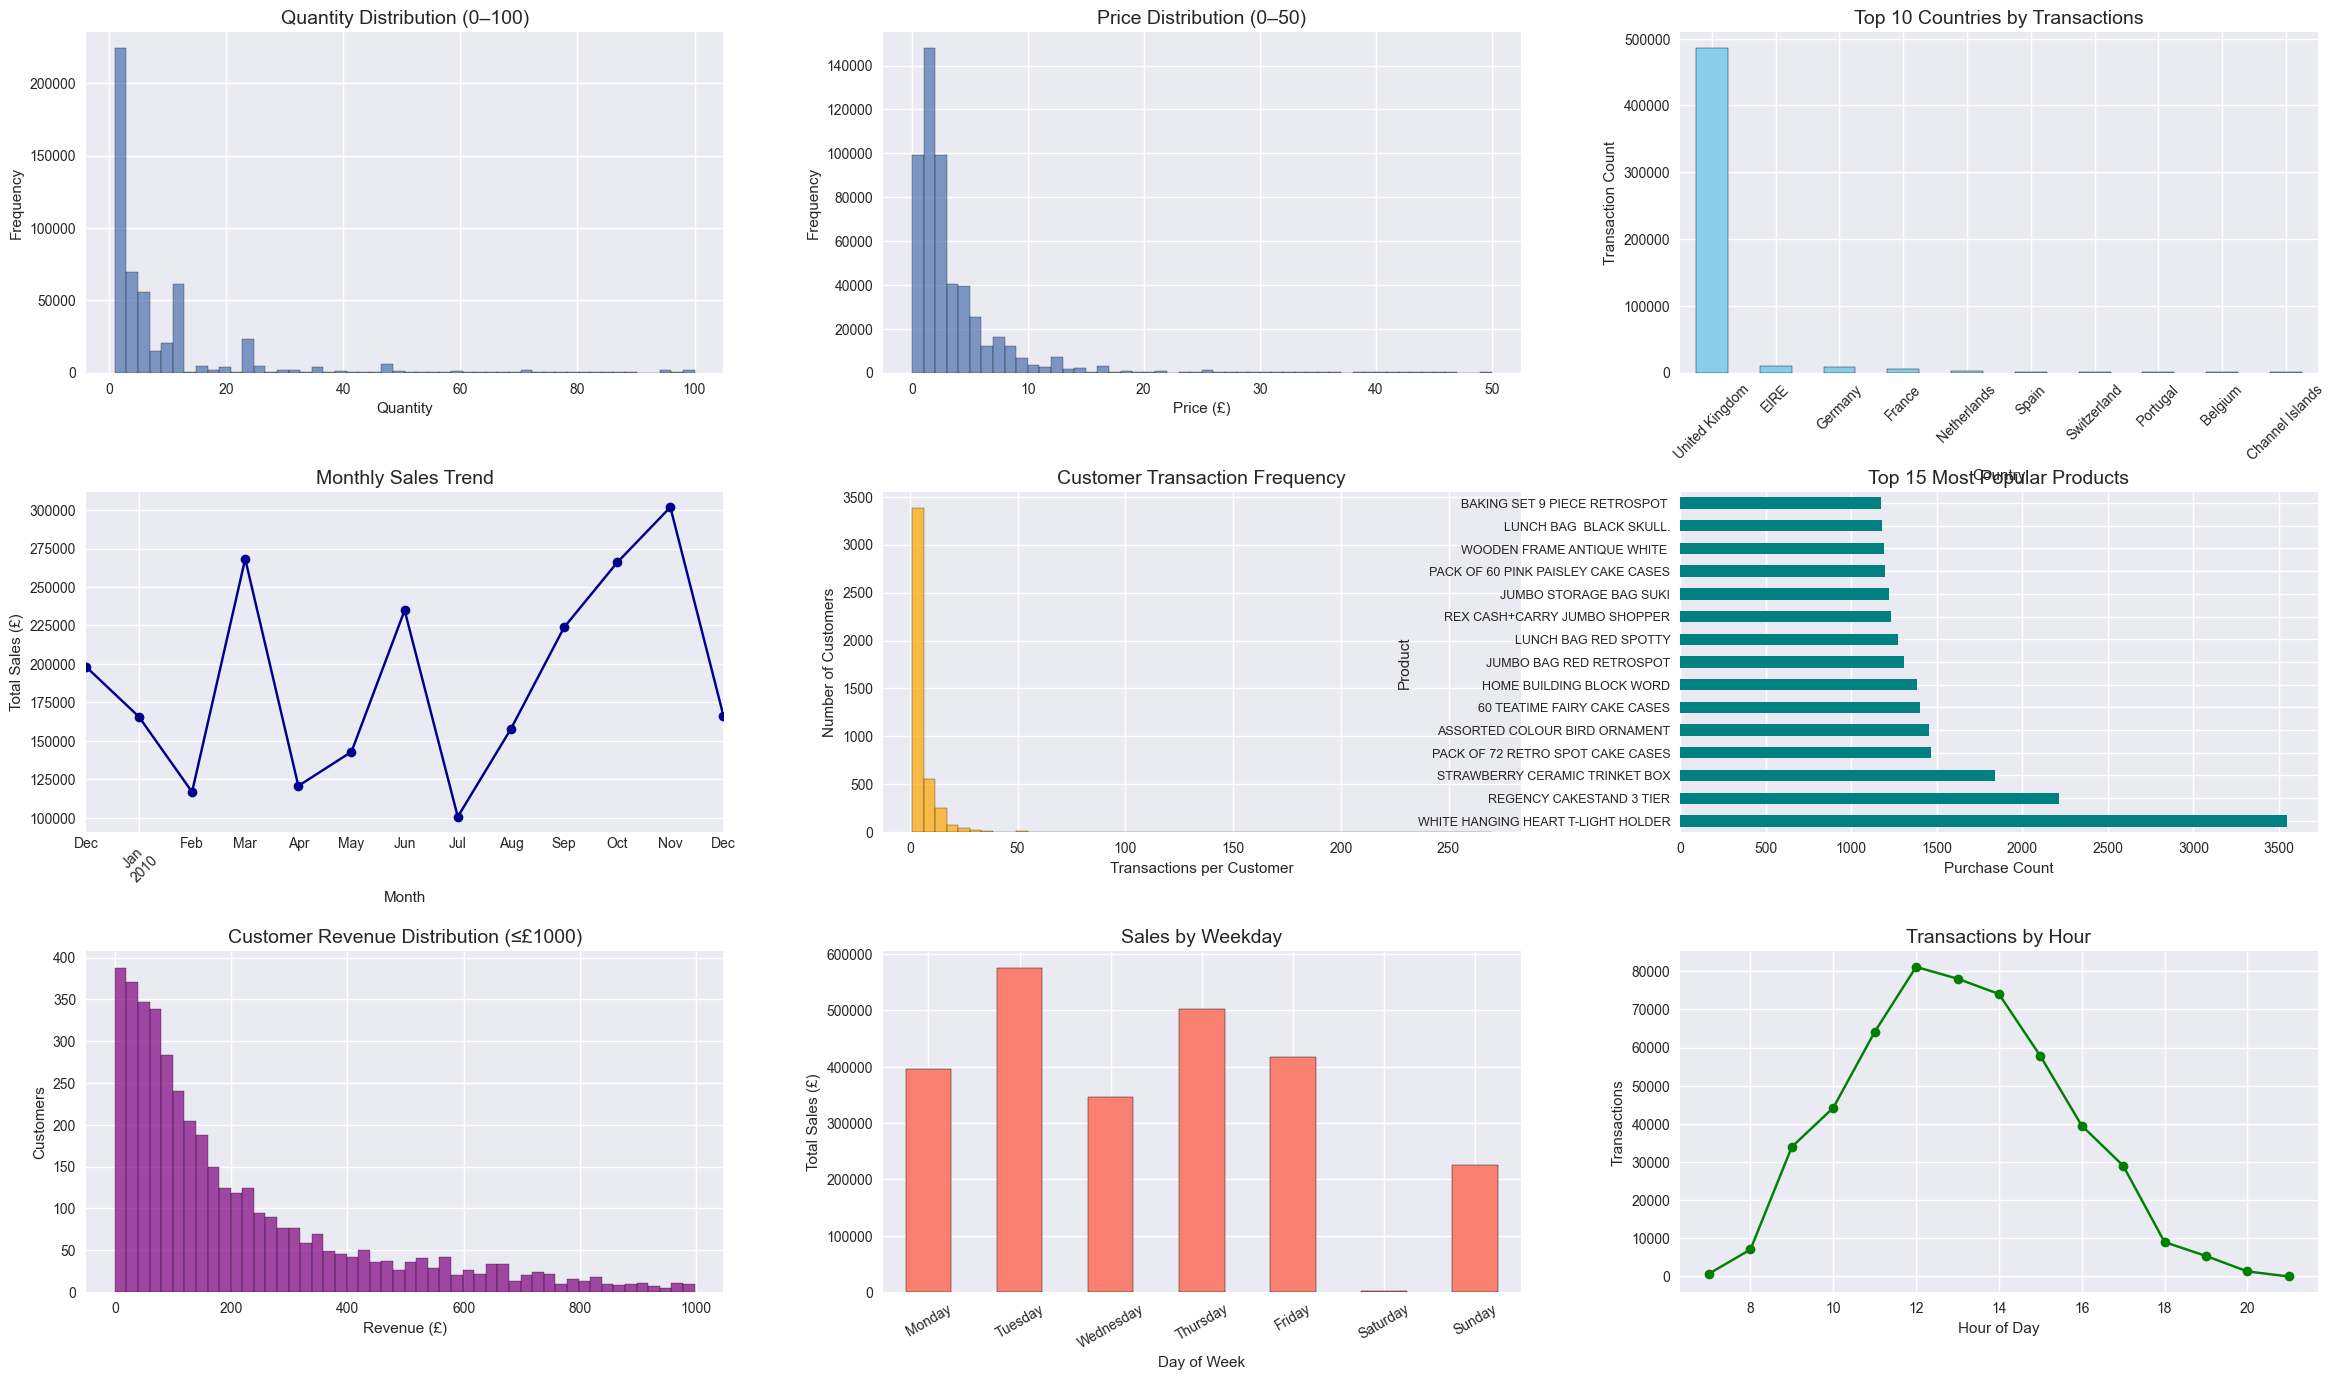

In [92]:
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("seaborn-v0_8")
fig, axes = plt.subplots(3, 3, figsize=(24, 14))  # wider and shorter
axes = axes.flatten()

# ---  Quantity distribution ---
quantity_filtered = df[df['Quantity'].between(0, 100)]['Quantity']
axes[0].hist(quantity_filtered, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Quantity Distribution (0–100)', fontsize=14)
axes[0].set_xlabel('Quantity')
axes[0].set_ylabel('Frequency')

# ---  Price distribution ---
price_filtered = df[df['Price'].between(0, 50)]['Price']
axes[1].hist(price_filtered, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_title('Price Distribution (0–50)', fontsize=14)
axes[1].set_xlabel('Price (£)')
axes[1].set_ylabel('Frequency')

# ---  Top countries ---
top_countries = df['Country'].value_counts().head(10)
top_countries.plot(kind='bar', ax=axes[2], color="skyblue", edgecolor="black")
axes[2].set_title('Top 10 Countries by Transactions', fontsize=14)
axes[2].set_xlabel('Country')
axes[2].set_ylabel('Transaction Count')
axes[2].tick_params(axis='x', rotation=45)

# ---  Monthly sales trend ---
df['YearMonth'] = pd.to_datetime(df['InvoiceDate']).dt.to_period('M')
monthly_sales = df.groupby('YearMonth')['Price'].sum()
monthly_sales.plot(kind='line', marker='o', ax=axes[3], color="darkblue")
axes[3].set_title('Monthly Sales Trend', fontsize=14)
axes[3].set_xlabel('Month')
axes[3].set_ylabel('Total Sales (£)')
axes[3].tick_params(axis='x', rotation=45)

# ---  Customer transaction frequency ---
customer_transactions = df.groupby('Customer ID')['Invoice'].nunique()
axes[4].hist(customer_transactions, bins=50, edgecolor='black', alpha=0.7, color="orange")
axes[4].set_title('Customer Transaction Frequency', fontsize=14)
axes[4].set_xlabel('Transactions per Customer')
axes[4].set_ylabel('Number of Customers')

# ---  Top products ---
top_products = df['Description'].value_counts().head(15)
top_products.plot(kind='barh', ax=axes[5], color="teal")
axes[5].set_title('Top 15 Most Popular Products', fontsize=14)
axes[5].set_xlabel('Purchase Count')
axes[5].set_ylabel('Product')
axes[5].tick_params(axis='y', labelsize=9)  # smaller font for long names

# ---  Revenue per customer ---
customer_revenue = df.groupby('Customer ID')['Price'].sum()
axes[6].hist(customer_revenue[customer_revenue <= 1000], bins=50, edgecolor='black', alpha=0.7, color="purple")
axes[6].set_title('Customer Revenue Distribution (≤£1000)', fontsize=14)
axes[6].set_xlabel('Revenue (£)')
axes[6].set_ylabel('Customers')

# ---  Weekday analysis ---
df['Weekday'] = pd.to_datetime(df['InvoiceDate']).dt.day_name()
weekday_sales = df.groupby('Weekday')['Price'].sum()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_sales = weekday_sales.reindex(weekday_order)
weekday_sales.plot(kind='bar', ax=axes[7], color="salmon", edgecolor="black")
axes[7].set_title('Sales by Weekday', fontsize=14)
axes[7].set_xlabel('Day of Week')
axes[7].set_ylabel('Total Sales (£)')
axes[7].tick_params(axis='x', rotation=30)

# ---  Hourly transactions ---
df['Hour'] = pd.to_datetime(df['InvoiceDate']).dt.hour
hourly_transactions = df.groupby('Hour').size()
hourly_transactions.plot(kind='line', marker='o', ax=axes[8], color="green")
axes[8].set_title('Transactions by Hour', fontsize=14)
axes[8].set_xlabel('Hour of Day')
axes[8].set_ylabel('Transactions')

plt.subplots_adjust(
    top=0.95, 
    bottom=0.05, 
    left=0.05, 
    right=0.98, 
    hspace=0.35, 
    wspace=0.25
)
plt.show()


## Data Cleaning Summary

The dataset was cleaned to ensure reliable analysis by removing cancelled orders, invalid quantities and prices, missing or duplicate customer records, and invalid dates. All columns were standardized, and the data was reindexed, resulting in a consistent and analysis-ready dataset.


In [93]:
import pandas as pd

df_clean = df.copy()

# Remove cancelled invoices (InvoiceNo starting with 'C')
df_clean = df_clean[~df_clean['Invoice'].astype(str).str.startswith('C')]

# Remove negative or zero Quantity and Price
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['Price'] > 0)]

# Drop rows with missing CustomerID
df_clean = df_clean.dropna(subset=['Customer ID'])

# Drop duplicates
df_clean = df_clean.drop_duplicates()

# Ensure InvoiceDate is datetime and handle errors
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'], errors='coerce')
df_clean = df_clean.dropna(subset=['InvoiceDate'])  # Remove rows where date conversion failed
df_clean['Customer ID'] = df_clean['Customer ID'].astype('int64')


df_clean = df_clean.reset_index(drop=True)


In [94]:
print("Original shape:", df.shape)
print("Cleaned shape :", df_clean.shape)

Original shape: (525461, 11)
Cleaned shape : (400916, 11)


In [95]:
print("\n--- Missing Values After Cleaning ---")
print(df_clean.isnull().sum())



--- Missing Values After Cleaning ---
Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
YearMonth      0
Weekday        0
Hour           0
dtype: int64


In [96]:
print("--- Sample Clean Data ---")
display(df_clean.head())

--- Sample Clean Data ---


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,YearMonth,Weekday,Hour
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,2009-12,Tuesday,7
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009-12,Tuesday,7
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009-12,Tuesday,7
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,2009-12,Tuesday,7
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,2009-12,Tuesday,7


## Data Cleaning Impact

The dataset was cleaned to ensure reliability and consistency. Cancelled orders, missing or invalid customer IDs, negative or zero quantities and prices, and duplicate rows were removed, resulting in a cleaner, analysis-ready dataset. Around 124,545 rows (23.7%) were removed.


In [97]:
# Data cleaning impact analysis
print("--- DATA CLEANING IMPACT ANALYSIS ---")
print(f"Original dataset: {df.shape[0]:,} rows")
print(f"After cleaning: {df_clean.shape[0]:,} rows")
print(f"Removed: {df.shape[0] - df_clean.shape[0]:,} rows ({(df.shape[0] - df_clean.shape[0])/df.shape[0]*100:.1f}%)")


# Verify data quality improvements
print(f"\nQuality checks after cleaning:")
print(f"- Missing Customer IDs: {df_clean['Customer ID'].isnull().sum()}")
print(f"- Negative quantities: {(df_clean['Quantity'] < 0).sum()}")
print(f"- Zero/negative prices: {(df_clean['Price'] <= 0).sum()}")
print(f"- Duplicate rows: {df_clean.duplicated().sum()}")

--- DATA CLEANING IMPACT ANALYSIS ---
Original dataset: 525,461 rows
After cleaning: 400,916 rows
Removed: 124,545 rows (23.7%)

Quality checks after cleaning:
- Missing Customer IDs: 0
- Negative quantities: 0
- Zero/negative prices: 0
- Duplicate rows: 0


## Cleaned Data Characteristics

The cleaned dataset contains **4,312 unique customers** and **4,444 unique products**, covering the period from **December 2009 to December 2010**. Total revenue amounts to **£1.33 million**, with an **average transaction value of £3.31**.


In [98]:
print("--- CLEANED DATA CHARACTERISTICS ---")
print(f"Unique customers: {df_clean['Customer ID'].nunique():,}")
print(f"Unique products: {df_clean['Description'].nunique():,}")
print(f"Date range: {df_clean['InvoiceDate'].min()} to {df_clean['InvoiceDate'].max()}")
print(f"Total revenue: £{df_clean['Price'].sum():,.2f}")
print(f"Average transaction value: £{df_clean['Price'].mean():.2f}")

--- CLEANED DATA CHARACTERISTICS ---
Unique customers: 4,312
Unique products: 4,444
Date range: 2009-12-01 07:45:00 to 2010-12-09 20:01:00
Total revenue: £1,325,358.59
Average transaction value: £3.31


## RFM and Customer Metrics Overview

After cleaning and outlier removal, the dataset contains **4,268 customers**.  

Key statistics:  
- **Recency:** Avg. 92 days since last purchase (1–374 days)  
- **Frequency:** Avg. 4 purchases per customer (1–94)  
- **Monetary:** Avg. £250 spent per customer (£0.19–£2,290)  
- **Total Quantity:** Avg. 1,117 items purchased (1–220,600)  
- **Product Variety:** Avg. 61 distinct products purchased (1–730)  

Log-transforming skewed metrics helped normalize distributions for clustering and further analysis. This is essential for clustering which rely more on distances. The Recency is not log tranformed as it doesn't have a long tail.


Reference date for recency: 2010-12-10 20:01:00
Before outlier removal: 4312 customers
After outlier removal: 4268 customers


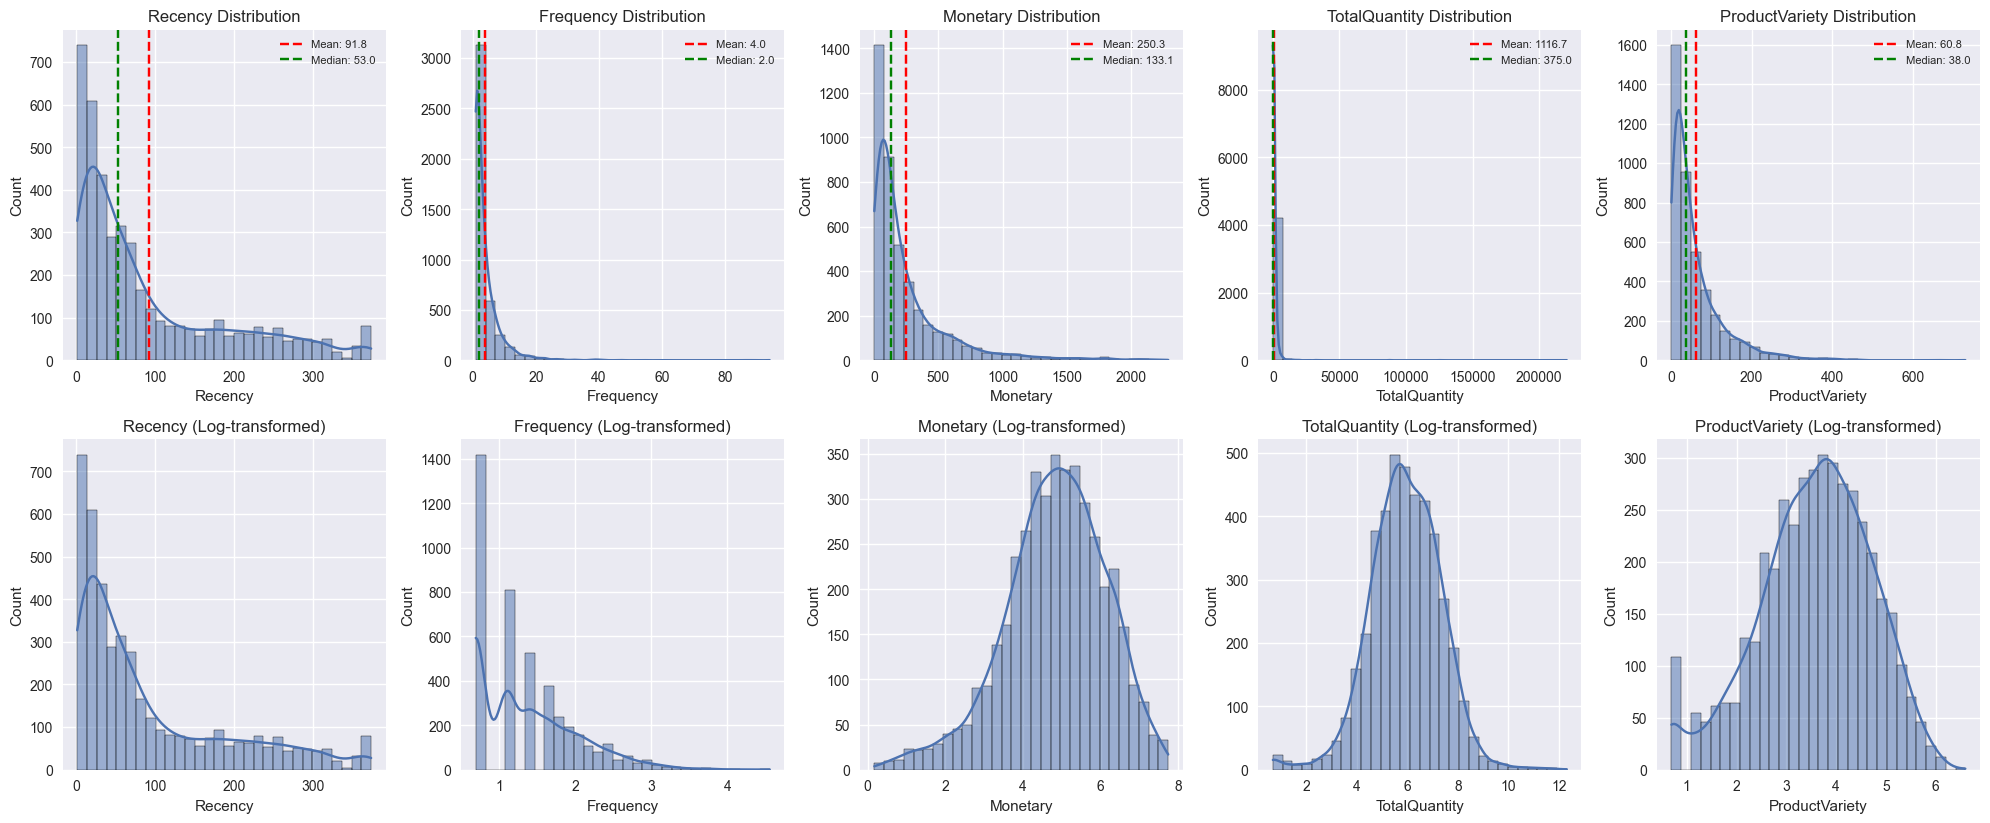

           Recency    Frequency     Monetary  TotalQuantity  ProductVariety
count  4268.000000  4268.000000  4268.000000    4268.000000     4268.000000
mean     91.750937     4.025070   250.254687    1116.684161       60.791940
std      96.985154     5.261262   319.459361    5456.648154       67.724876
min       1.000000     1.000000     0.190000       1.000000        1.000000
25%      19.000000     1.000000    56.180000     155.000000       17.000000
50%      53.000000     2.000000   133.100000     375.000000       38.000000
75%     137.000000     5.000000   309.320000     966.250000       79.000000
max     374.000000    94.000000  2290.540000  220600.000000      730.000000


In [99]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score

ref_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"Reference date for recency: {ref_date}")

rfm = df_clean.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,  # Recency (days)
    'Invoice': 'nunique',                                # Frequency (unique invoices)
    'Price': 'sum'                                       # Monetary (total spent)
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

customer_metrics = df_clean.groupby('Customer ID').agg({
    'Quantity': ['sum', 'mean'],                         # Total and average quantity
    'Description': 'nunique',                            # Product variety
    'InvoiceDate': lambda x: (x.max() - x.min()).days   # Customer lifetime span
}).reset_index()

customer_metrics.columns = ['CustomerID', 'TotalQuantity', 'AvgQuantity', 'ProductVariety', 'LifetimeSpan']
rfm = rfm.merge(customer_metrics, on='CustomerID')

print(f"Before outlier removal: {len(rfm)} customers")
rfm = rfm[(rfm['Monetary'] > 0) & (rfm['Frequency'] > 0)]
rfm = rfm[rfm['Monetary'] <= rfm['Monetary'].quantile(0.99)]  # Remove top 1% to reduce skewness
print(f"After outlier removal: {len(rfm)} customers")

plt.figure(figsize=(20, 12))

for i, col in enumerate(['Recency', 'Frequency', 'Monetary', 'TotalQuantity', 'ProductVariety']):
    plt.subplot(3, 5, i+1)
    sns.histplot(rfm[col], kde=True, bins=30)
    plt.title(f'{col} Distribution')
    
    # Add statistical annotations
    mean_val = rfm[col].mean()
    median_val = rfm[col].median()
    plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.1f}')
    plt.axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.1f}')
    plt.legend(fontsize=8)

rfm_log = rfm.copy()
for col in ['Frequency', 'Monetary', 'TotalQuantity', 'ProductVariety']:
    rfm_log[col] = np.log1p(rfm_log[col])

# Log-transformed distributions
for i, col in enumerate(['Recency', 'Frequency', 'Monetary', 'TotalQuantity', 'ProductVariety']):
    plt.subplot(3, 5, i+6)
    sns.histplot(rfm_log[col], kde=True, bins=30)
    plt.title(f'{col} (Log-transformed)')

plt.tight_layout()
plt.show()

print(rfm[['Recency', 'Frequency', 'Monetary', 'TotalQuantity', 'ProductVariety']].describe())


## RFM Feature Correlation Analysis

### Key Insights from Correlation Matrix

**Strong Positive Correlations:**
- **Monetary -- ProductVariety** (r = 0.88): Customers who spend more tend to purchase diverse products
- **Frequency -- Monetary** (r = 0.66): More frequent buyers also tend to spend more
- **Frequency -- ProductVariety** (r = 0.55): Frequent customers explore wider product ranges

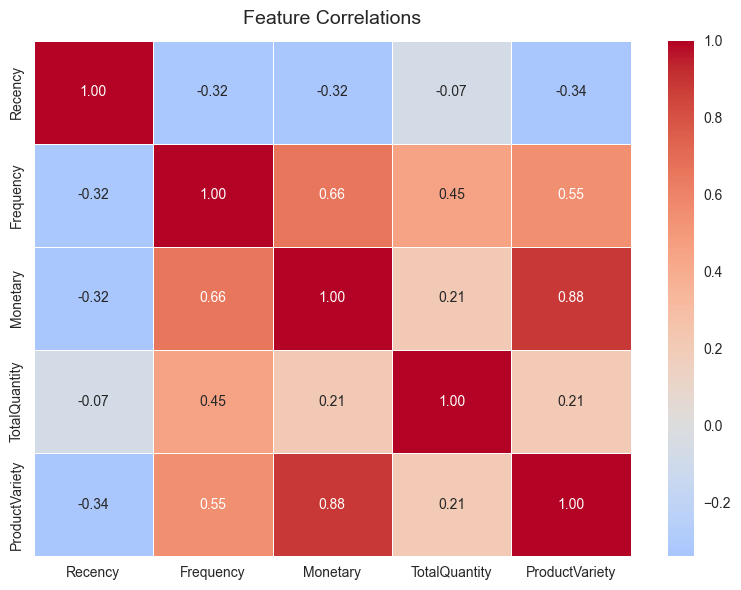

In [100]:

correlation_matrix = rfm[['Recency', 'Frequency', 'Monetary', 'TotalQuantity', 'ProductVariety']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    center=0, 
    fmt='.2f',
    linewidths=0.5,
    cbar=True
)
plt.title('Feature Correlations', fontsize=14, pad=12)
plt.tight_layout()
plt.show()


# PCA + K-Means Clustering Summary

RFM features (`Recency`, `Frequency`, `Monetary`) for 4,268 customers were scaled and reduced to 2 dimensions using PCA. K-Means clustering (k=2–10) was evaluated using Inertia, Silhouette Score, and Davies-Bouldin Index. Metrics indicate **3 clusters** as optimal, balancing compactness and separation. Visualizations confirm cluster quality and highlight the selected k.


PCA-transformed shape: (4268, 2)
k=2: Inertia=5692.68, Silhouette=0.434, Davies-Bouldin=0.865
k=3: Inertia=3366.69, Silhouette=0.455, Davies-Bouldin=0.764
k=4: Inertia=2441.10, Silhouette=0.417, Davies-Bouldin=0.761
k=5: Inertia=2019.08, Silhouette=0.414, Davies-Bouldin=0.818
k=6: Inertia=1663.51, Silhouette=0.377, Davies-Bouldin=0.847
k=7: Inertia=1443.62, Silhouette=0.380, Davies-Bouldin=0.834
k=8: Inertia=1264.93, Silhouette=0.364, Davies-Bouldin=0.868
k=9: Inertia=1124.27, Silhouette=0.372, Davies-Bouldin=0.819
k=10: Inertia=1002.91, Silhouette=0.364, Davies-Bouldin=0.840

Optimal number of clusters: 3


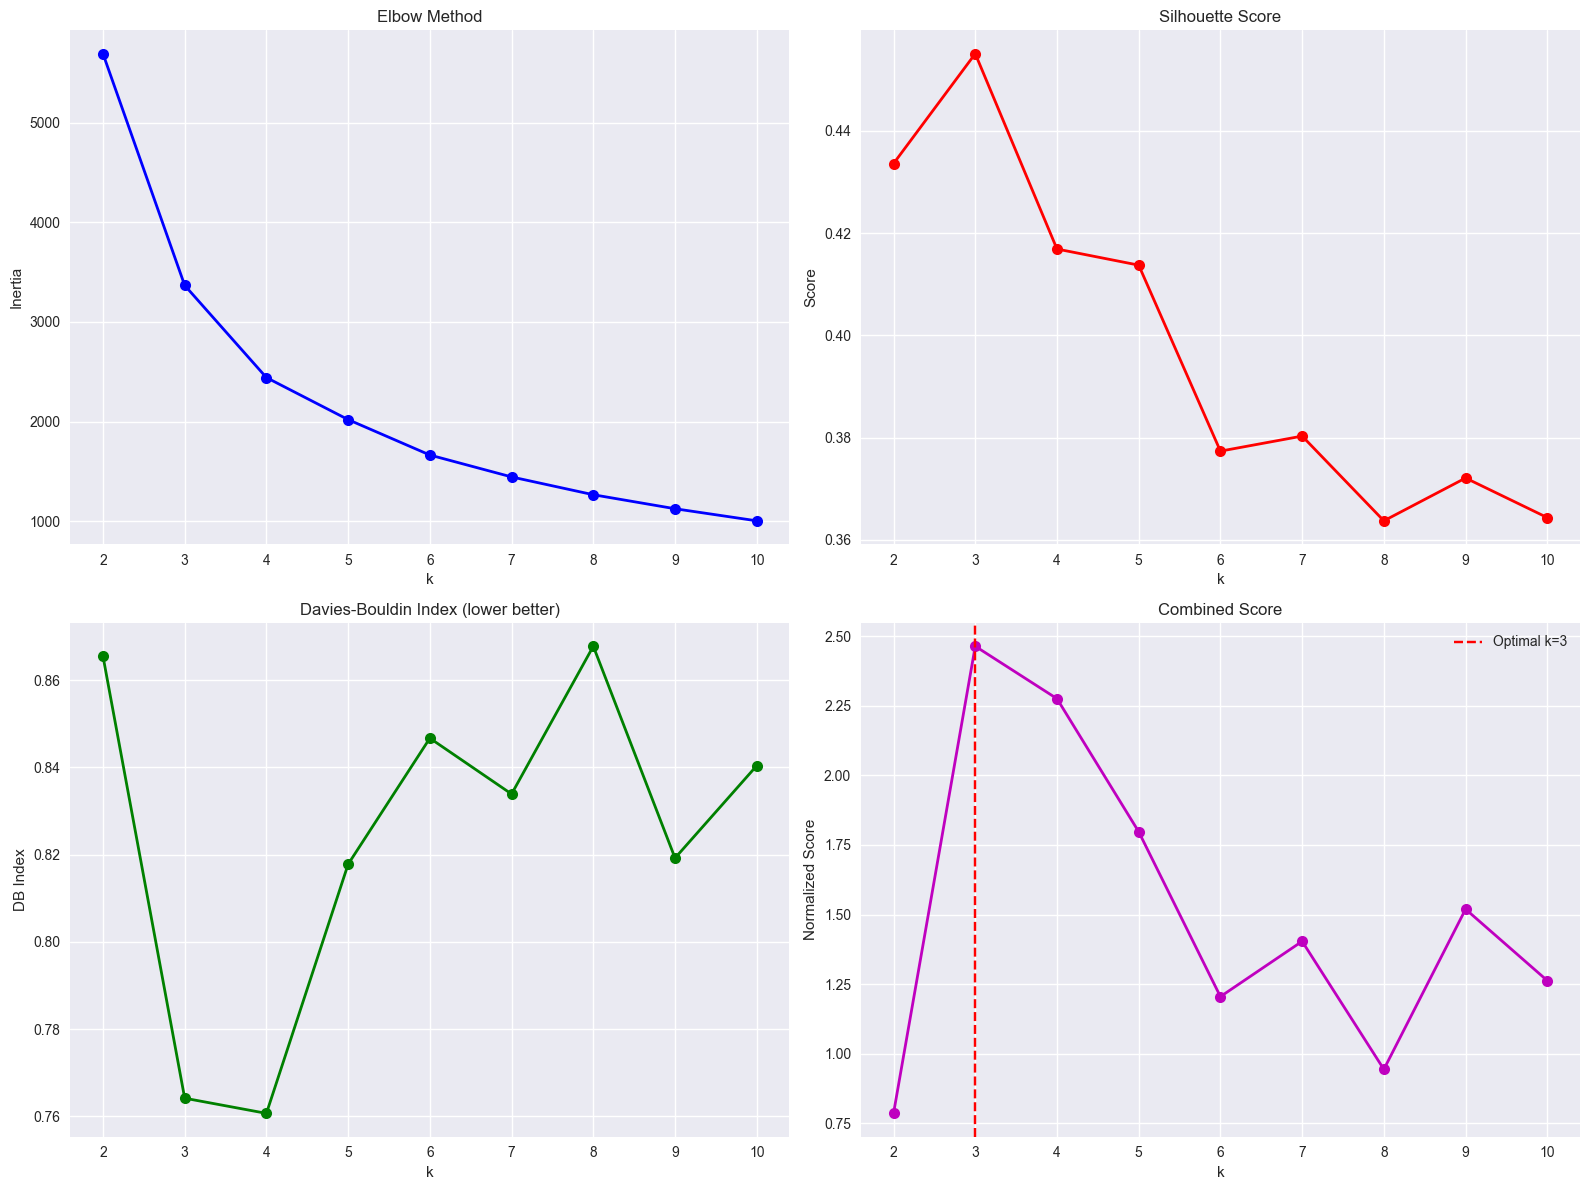

In [101]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

feature_cols = ['Recency', 'Frequency', 'Monetary']
X = rfm_log[feature_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA-transformed shape: {X_pca.shape}")

rfm['PCA1'] = X_pca[:, 0]
rfm['PCA2'] = X_pca[:, 1]

# --- K-Means clustering parameters sweeping---
inertia, silhouette, davies_bouldin = [], [], []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=300)
    labels = kmeans.fit_predict(X_pca)
    
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_pca, labels))
    davies_bouldin.append(davies_bouldin_score(X_pca, labels))
    
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, "
          f"Silhouette={silhouette_score(X_pca, labels):.3f}, "
          f"Davies-Bouldin={davies_bouldin_score(X_pca, labels):.3f}")

norm_inertia = [(max(inertia)-i)/(max(inertia)-min(inertia)) for i in inertia]
norm_silhouette = [(s - min(silhouette))/(max(silhouette)-min(silhouette)) for s in silhouette]
norm_db = [(max(davies_bouldin)-db)/(max(davies_bouldin)-min(davies_bouldin)) for db in davies_bouldin]
combined_score = [sum(x) for x in zip(norm_inertia, norm_silhouette, norm_db)]
optimal_k = K[combined_score.index(max(combined_score))]
print(f"\nOptimal number of clusters: {optimal_k}")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].plot(K, inertia, 'bo-', markersize=8, linewidth=2)
axes[0, 0].set_title("Elbow Method")
axes[0, 0].set_xlabel("k")
axes[0, 0].set_ylabel("Inertia")

axes[0, 1].plot(K, silhouette, 'ro-', markersize=8, linewidth=2)
axes[0, 1].set_title("Silhouette Score")
axes[0, 1].set_xlabel("k")
axes[0, 1].set_ylabel("Score")

axes[1, 0].plot(K, davies_bouldin, 'go-', markersize=8, linewidth=2)
axes[1, 0].set_title("Davies-Bouldin Index (lower better)")
axes[1, 0].set_xlabel("k")
axes[1, 0].set_ylabel("DB Index")

axes[1, 1].plot(K, combined_score, 'mo-', markersize=8, linewidth=2)
axes[1, 1].axvline(optimal_k, color='red', linestyle='--', label=f'Optimal k={optimal_k}')
axes[1, 1].set_title("Combined Score")
axes[1, 1].set_xlabel("k")
axes[1, 1].set_ylabel("Normalized Score")
axes[1, 1].legend()

plt.tight_layout()
plt.show()


# Final K-Means Clustering (k=3)

- **Silhouette Score**: 0.455  
- **Cluster Distribution**: Balanced across 3 clusters.  
- **Insights**: Each cluster shows distinct RFM and engagement patterns, highlighting differences in customer recency, frequency, and monetary value.

# Cluster Interpretation (k=3)

- **Cluster 0 – Loyal & Frequent Customers**  
  High frequency and monetary value, low recency → recent, engaged, and valuable customers.

- **Cluster 1 – Occasional Customers**  
  Moderate frequency and spending, medium recency → purchase occasionally, moderate value.

- **Cluster 2 – Inactive or Low-Value Customers**  
  Low frequency and monetary value, high recency → haven’t purchased recently, least engaged.



In [102]:
k_final = 3
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=20, max_iter=300, algorithm='lloyd')
rfm['Cluster'] = kmeans_final.fit_predict(X_pca)

final_silhouette = silhouette_score(X_scaled, rfm['Cluster'])
print(f"Final model performance:")
print(f"- Silhouette score: {final_silhouette:.3f}")

cluster_counts = rfm['Cluster'].value_counts().sort_index()
print("Cluster distribution:")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count:,} customers ({count/len(rfm)*100:.1f}%)")

cluster_profiles = rfm.groupby('Cluster')[['Recency','Frequency','Monetary','TotalQuantity','ProductVariety','LifetimeSpan']].agg(['mean','median','std']).round(2)
display(cluster_profiles)



Final model performance:
- Silhouette score: 0.390
Cluster distribution:
Cluster 0: 932 customers (21.8%)
Cluster 1: 1,569 customers (36.8%)
Cluster 2: 1,767 customers (41.4%)


Recency               Frequency              Monetary                  \
           mean median    std      mean median   std     mean  median     std   
Cluster                                                                         
0        252.68  246.0  62.90      1.44    1.0  0.86    85.73   59.94   97.73   
1         36.04   22.0  39.63      7.93    6.0  7.03   521.33  401.80  386.68   
2         56.34   49.0  39.59      1.92    2.0  1.05    96.33   79.75   74.29   

        TotalQuantity                  ProductVariety                \
                 mean  median      std           mean median    std   
Cluster                                                               
0              505.89   146.0  7250.41          23.72   18.0  23.99   
1             2187.36  1126.0  6262.13         117.44   96.0  80.15   
2              488.14   250.0  2793.01          30.04   25.0  23.50   

        LifetimeSpan                 
                mean median     std  
Cluster                              
0              20.94    0.0   43.80  
1             252.00  267.0   95.98  
2              84.57   21.0  106.16

# K-Means Cluster Visualization Summary

- **Scatter Plots**:
  - *Recency vs Monetary*: Shows how recent purchases relate to spending across clusters. Cluster 0 has high spending and recent activity; Cluster 2 has low spending and older activity.
  - *Frequency vs Monetary*: Highlights transaction behavior. Frequent, high-spending customers cluster together, while infrequent or low-value customers form separate clusters.

- **Box Plots**:
  - *Recency by Cluster*: Confirms Cluster 0 is recent, Cluster 1 is moderate, Cluster 2 is older.
  - *Monetary by Cluster*: Confirms Cluster 0 has highest spending, Cluster 1 moderate, Cluster 2 lowest.

- **Insight**: Visuals reinforce RFM-based segmentation, showing distinct customer behavior patterns across clusters.


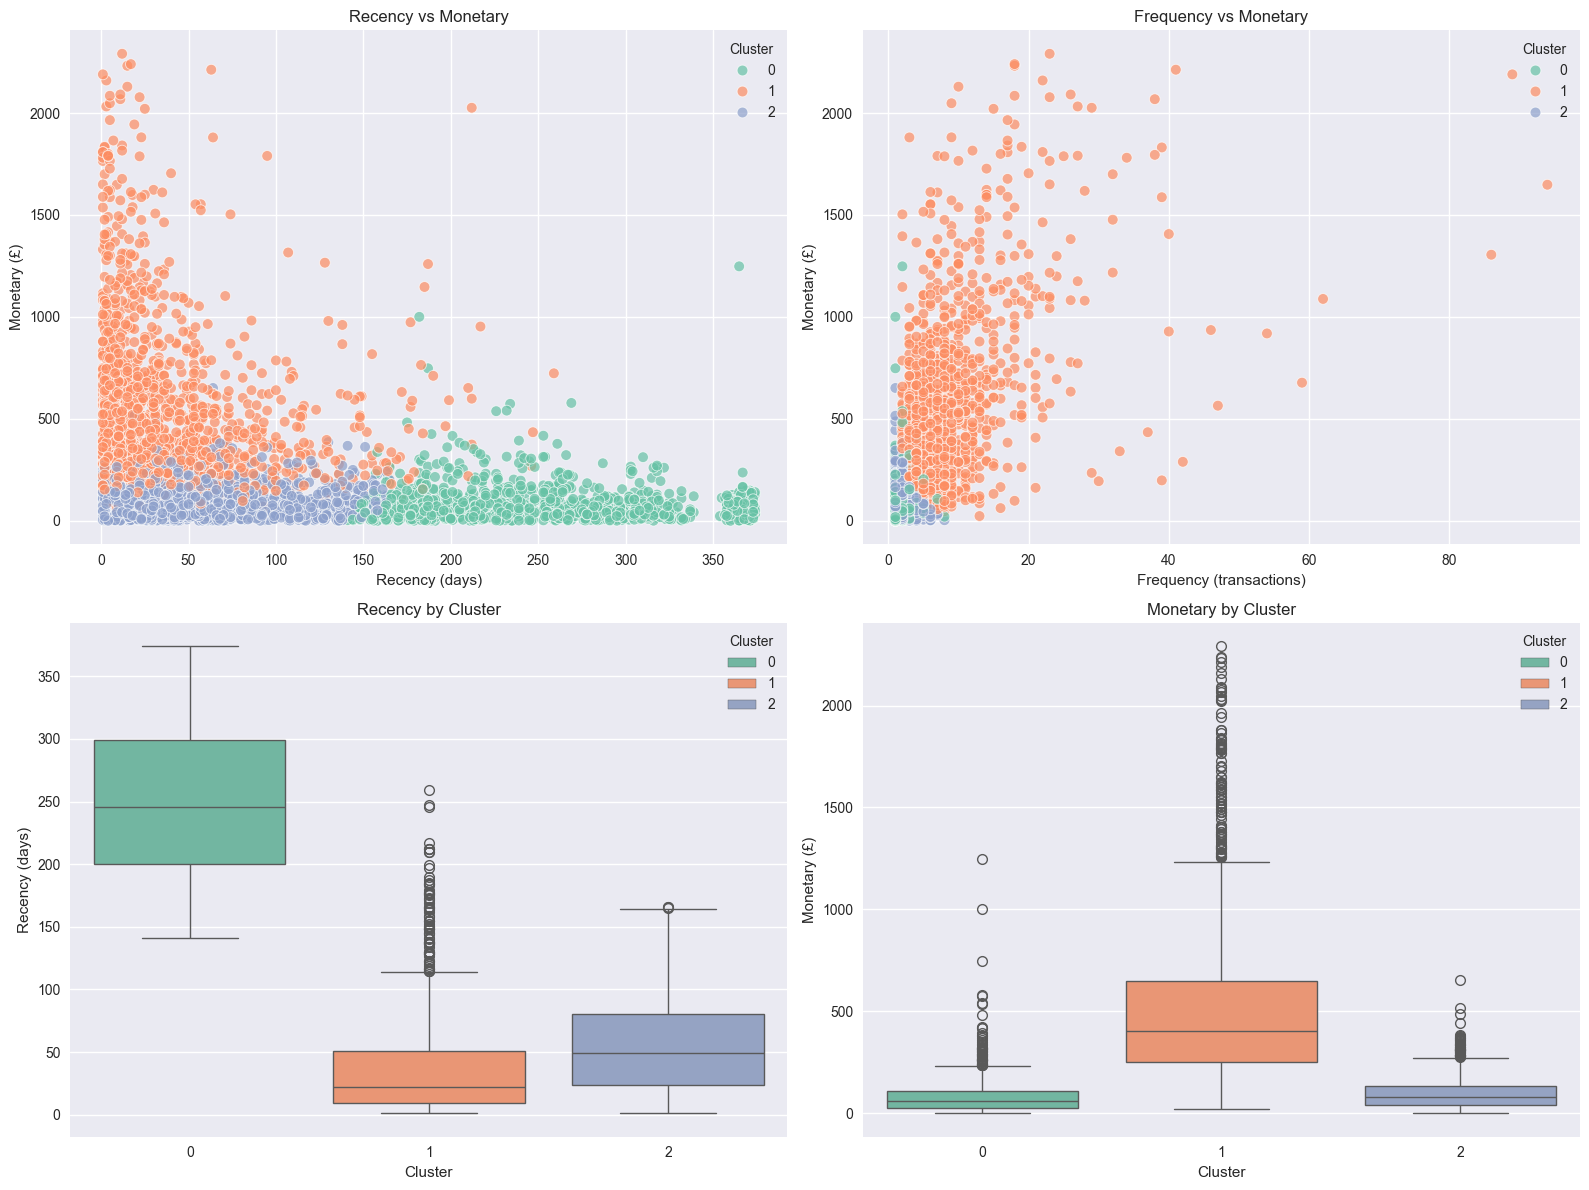

In [103]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', palette='Set2', data=rfm, ax=axes[0, 0], s=60, alpha=0.7)
axes[0, 0].set_title("Recency vs Monetary")
axes[0, 0].set_xlabel("Recency (days)")
axes[0, 0].set_ylabel("Monetary (£)")

sns.scatterplot(x='Frequency', y='Monetary', hue='Cluster', palette='Set2', data=rfm, ax=axes[0, 1], s=60, alpha=0.7)
axes[0, 1].set_title("Frequency vs Monetary")
axes[0, 1].set_xlabel("Frequency (transactions)")
axes[0, 1].set_ylabel("Monetary (£)")

rfm_melted = pd.melt(rfm[['Cluster','Recency','Frequency','Monetary']], id_vars=['Cluster'], var_name='RFM_Dimension', value_name='Value')
sns.boxplot(data=rfm_melted[rfm_melted['RFM_Dimension']=='Recency'], x='Cluster', y='Value', ax=axes[1, 0], palette='Set2', hue='Cluster')
axes[1, 0].set_title("Recency by Cluster")
axes[1, 0].set_ylabel("Recency (days)")

sns.boxplot(data=rfm_melted[rfm_melted['RFM_Dimension']=='Monetary'], x='Cluster', y='Value', ax=axes[1, 1], palette='Set2', hue='Cluster')
axes[1, 1].set_title("Monetary by Cluster")
axes[1, 1].set_ylabel("Monetary (£)")

plt.tight_layout()
plt.show()


# K-Means Clustering Summary (k=3)

- **Data**: RFM features for 4,268 customers, scaled and reduced to 2D via PCA (89.6% variance explained).  
- **PCA Interpretation**:  
  - **PCA1 (67.65%)**: High values correspond to customers with **high Frequency and Monetary** and **low Recency** (recent buyers).  
  - **PCA2 (21.9%)**: Emphasizes **Recency** (loading ~0.86) while still influenced by Frequency and Monetary; orthogonal to PCA1.  
- **Silhouette Score**: 0.455 → good separation.  
- **Clusters**:  
  - Cluster 0: Loyal & frequent, high spending, recent activity.  
  - Cluster 1: Occasional, moderate spending and recency.  
  - Cluster 2: Inactive/low-value, low spending, long since last purchase.  
- **Visualization**: Scatter plots and PCA projection show clear, well-separated clusters.  
- **Insight**: Clustering captures distinct customer behaviors, supporting targeted marketing and retention strategies.


PCA Explained Variance Ratio: PC1=0.676, PC2=0.219
Total variance explained by 2 components: 0.896


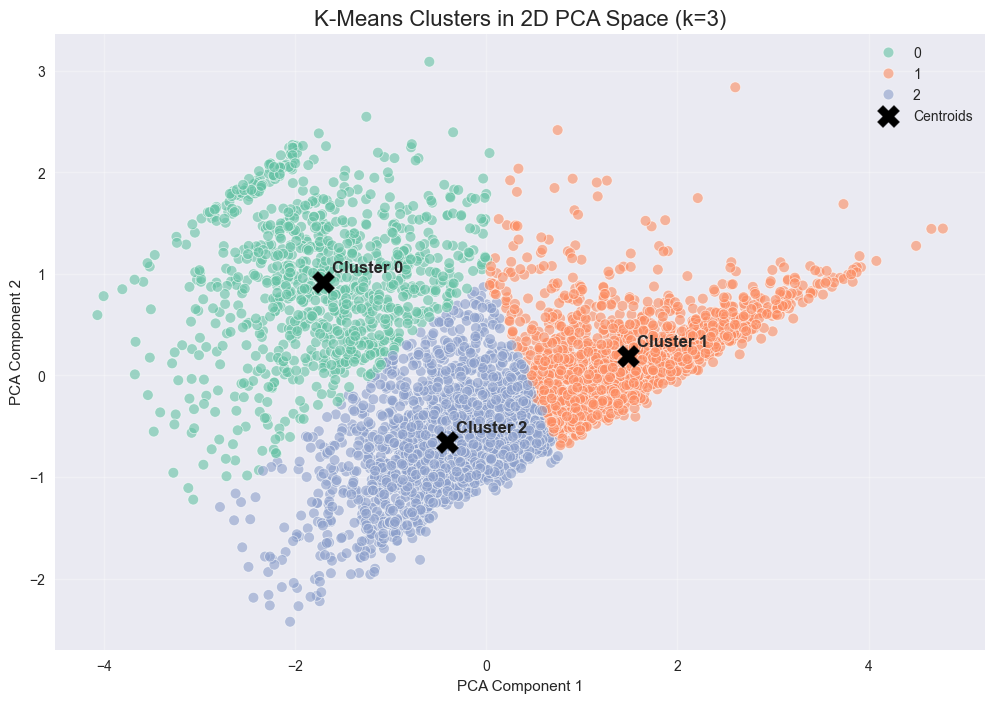

In [104]:
# --- Project centroids in PCA space ---
explained_var = pca.explained_variance_ratio_
print(f"PCA Explained Variance Ratio: PC1={explained_var[0]:.3f}, PC2={explained_var[1]:.3f}")
print(f"Total variance explained by 2 components: {explained_var.sum():.3f}")


centroids_pca = kmeans_final.cluster_centers_

# --- Plot clusters ---
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=rfm, x='PCA1', y='PCA2',
    hue='Cluster', palette='Set2',
    s=60, alpha=0.6
)

# Plot centroids s
plt.scatter(
    centroids_pca[:, 0], centroids_pca[:, 1],
    c='black', marker='X', s=250, label='Centroids'
)

for i, (x, y) in enumerate(centroids_pca):
    plt.text(x + 0.1, y + 0.1, f'Cluster {i}', fontsize=12, weight='bold')

plt.title(f'K-Means Clusters in 2D PCA Space (k={optimal_k})', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Cluster Interpretation

| Cluster | Interpretation |
|---------|----------------|
| **0**   | Occasional, medium-value customers → purchase somewhat recently, low-to-medium spend |
| **1**   | Active, high-value customers → frequent buyers, recent purchase, highest spend |
| **2**   | Inactive, low-value customers → haven’t purchased for a long time, low frequency, low spend |



# Agglomerative Clustering Summary

- **Data**: PCA-reduced RFM features (2 components) for 4,268 customers.  
- **Method**: Agglomerative Clustering tested with 3–7 clusters and linkages: `ward`, `complete`, `average`, `single`.  
- **Evaluation**: Silhouette Score used to measure cluster separation.  

- **Results**:  
  - Best configuration: **3 clusters, Ward linkage**, Silhouette ≈ 0.41.  
  - Other linkages and larger cluster numbers had lower silhouette scores.  

- **Discussion**:  
  - Ward linkage produces the most compact and well-separated clusters in PCA space.  
  - Silhouette score decreases as cluster count increases, suggesting over-segmentation can reduce cohesion.  
  - Choosing 3 clusters aligns with business practice for RFM segmentation (High, Medium, Low value), balancing statistical separation and interpretability.



In [105]:
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

pca = PCA(n_components=2)  # reduce to 2 components for visualization
X_pca = pca.fit_transform(X_scaled)
print(f"PCA-transformed shape: {X_pca.shape}")

n_clusters_range = range(3, 8)
linkage_methods = ['ward', 'complete', 'average', 'single']

results = []

for n_clusters in n_clusters_range:
    for linkage_method in linkage_methods:
        metric = 'euclidean' if linkage_method == 'ward' else 'manhattan'
        
        agglo = AgglomerativeClustering(
            n_clusters=n_clusters,
            linkage=linkage_method,
            metric=metric
        )
        labels = agglo.fit_predict(X_pca)
        
        sil = silhouette_score(X_pca, labels)
        results.append({
            'n_clusters': n_clusters,
            'linkage': linkage_method,
            'silhouette': sil
        })
        print(f"Clusters={n_clusters}, Linkage={linkage_method} -> Silhouette={sil:.3f}")

results_df = pd.DataFrame(results)

best_idx = results_df['silhouette'].idxmax()
best_config = results_df.loc[best_idx]
print("\nBest Agglomerative Clustering configuration (based on Silhouette Score):")
print(best_config)


PCA-transformed shape: (4268, 2)
Clusters=3, Linkage=ward -> Silhouette=0.410
Clusters=3, Linkage=complete -> Silhouette=0.217
Clusters=3, Linkage=average -> Silhouette=0.223
Clusters=3, Linkage=single -> Silhouette=0.332
Clusters=4, Linkage=ward -> Silhouette=0.373
Clusters=4, Linkage=complete -> Silhouette=0.385
Clusters=4, Linkage=average -> Silhouette=0.313
Clusters=4, Linkage=single -> Silhouette=0.303
Clusters=5, Linkage=ward -> Silhouette=0.364
Clusters=5, Linkage=complete -> Silhouette=0.377
Clusters=5, Linkage=average -> Silhouette=0.287
Clusters=5, Linkage=single -> Silhouette=0.234
Clusters=6, Linkage=ward -> Silhouette=0.338
Clusters=6, Linkage=complete -> Silhouette=0.346
Clusters=6, Linkage=average -> Silhouette=0.365
Clusters=6, Linkage=single -> Silhouette=0.236
Clusters=7, Linkage=ward -> Silhouette=0.332
Clusters=7, Linkage=complete -> Silhouette=0.298
Clusters=7, Linkage=average -> Silhouette=0.357
Clusters=7, Linkage=single -> Silhouette=0.179

Best Agglomerative Cl

# Agglomerative Clustering Summary (3 Clusters)

- **Data**: PCA-reduced RFM features (2 components, 89.6% variance explained).  
- **Clusters**: 3 clusters (Ward linkage), distributed as:  
  - Cluster 0: 2,086 customers (48.9%)  
  - Cluster 1: 1,097 customers (25.7%)  
  - Cluster 2: 1,085 customers (25.4%)  
- **Performance**: Silhouette score = 0.410

**Discussion**:  
- Ward linkage produces compact, well-separated clusters in PCA space.  
- Cluster sizes are reasonably balanced, aligning with typical RFM-based segmentation (High, Medium, Low value).  
- Silhouette score is slightly better than K-Means (0.39), reflecting differences in hierarchical vs. centroid-based clustering.  


Agglomerative clustering with 3 clusters completed
  Cluster 0: 2,086 customers (48.9%)
  Cluster 1: 1,097 customers (25.7%)
  Cluster 2: 1,085 customers (25.4%)

Agglomerative clustering performance:
- Silhouette score: 0.410


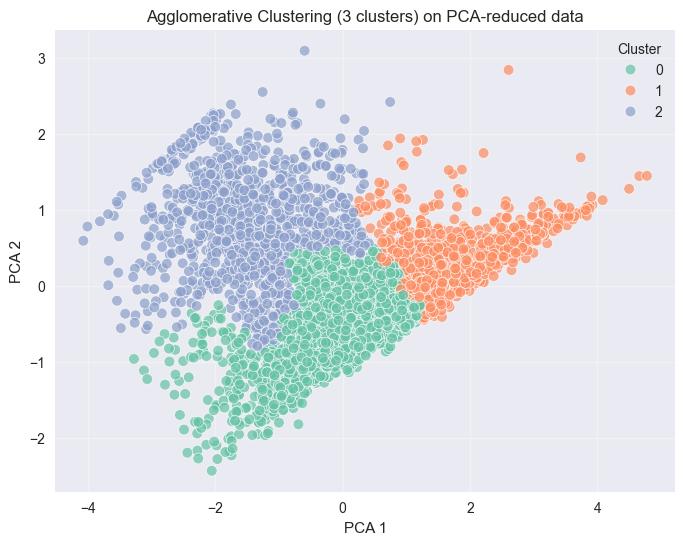

In [106]:
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

n_clusters = 3
linkage_method = "ward"

agglo = AgglomerativeClustering(
    n_clusters=n_clusters, 
    linkage=linkage_method, 
    metric='euclidean'
)
rfm['Agglo_Cluster'] = agglo.fit_predict(X_pca)

print(f"Agglomerative clustering with {n_clusters} clusters completed")
agglo_counts = rfm['Agglo_Cluster'].value_counts().sort_index()
for cluster, count in agglo_counts.items():
    percentage = count / len(rfm) * 100
    print(f"  Cluster {cluster}: {count:,} customers ({percentage:.1f}%)")

agglo_silhouette = silhouette_score(X_pca, rfm['Agglo_Cluster'])
agglo_db = davies_bouldin_score(X_pca, rfm['Agglo_Cluster'])
nmi = normalized_mutual_info_score(rfm['Cluster'], rfm['Agglo_Cluster'])

print(f"\nAgglomerative clustering performance:")
print(f"- Silhouette score: {agglo_silhouette:.3f}")

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=rfm['Agglo_Cluster'], palette='Set2', s=60, alpha=0.7)
plt.title(f"Agglomerative Clustering ({n_clusters} clusters) on PCA-reduced data")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='Cluster')
plt.grid(alpha=0.3)
plt.show()


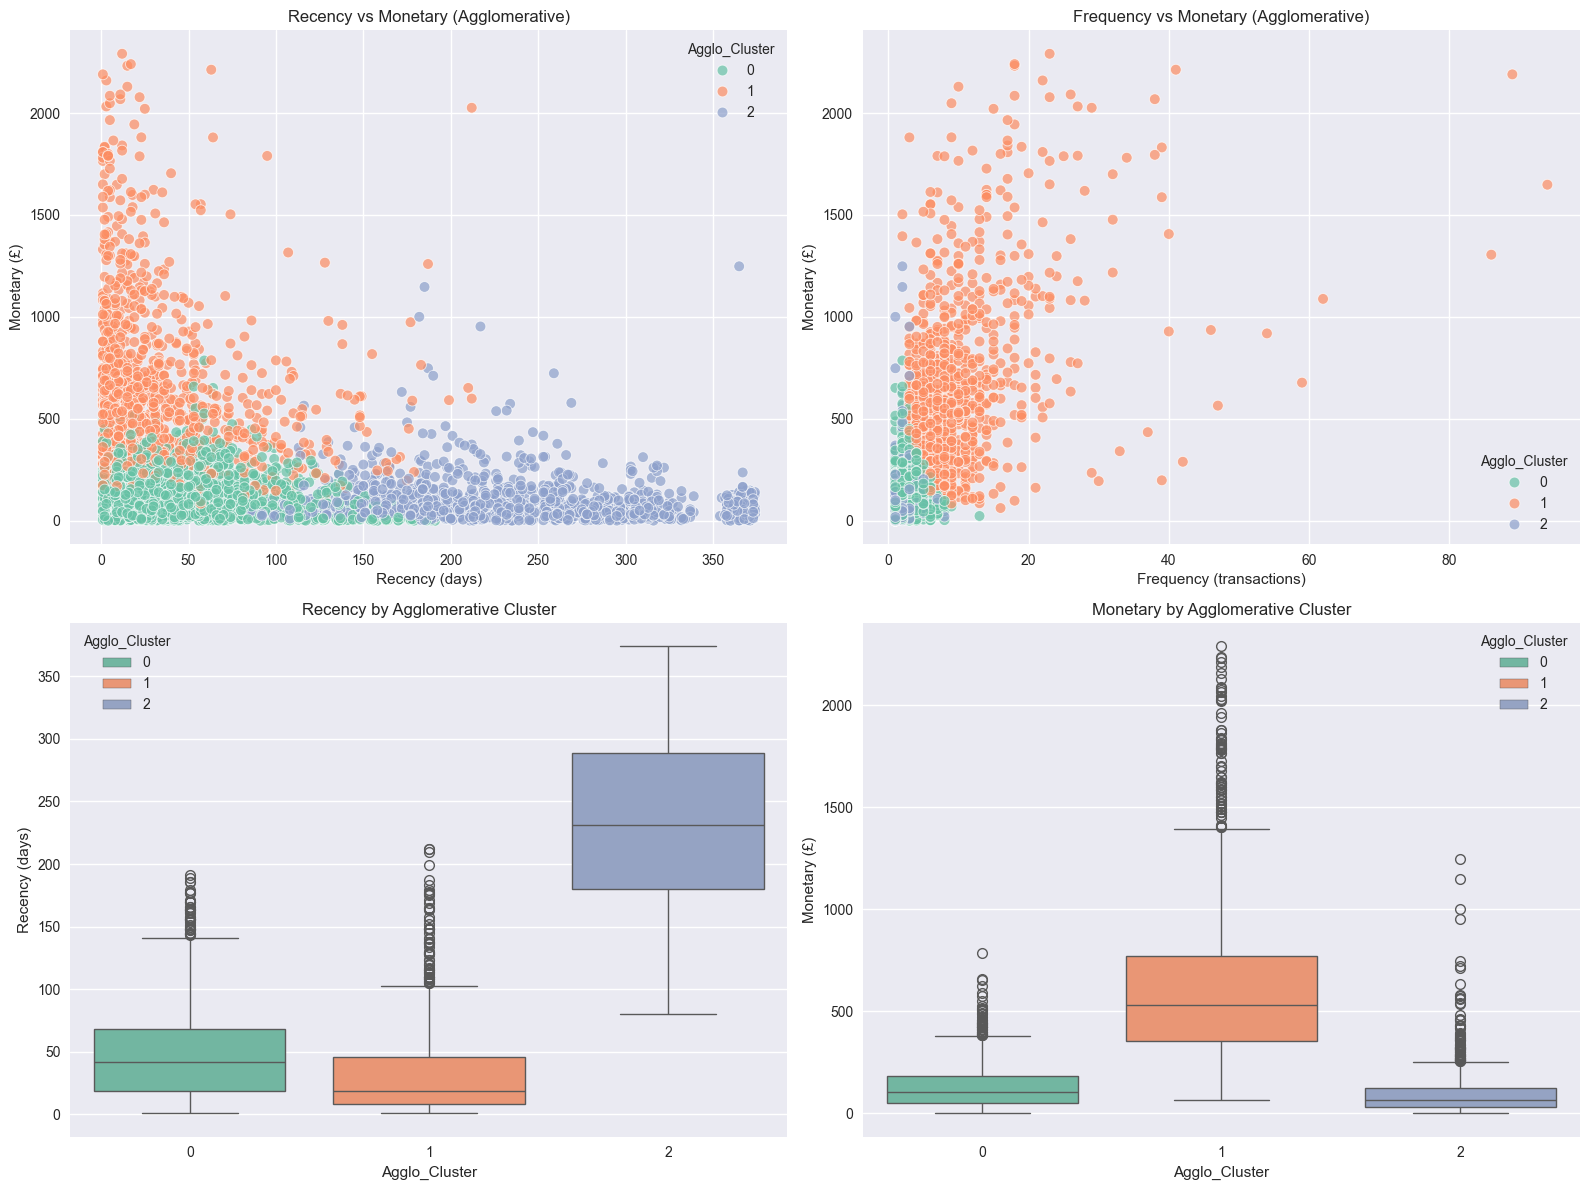

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sample_data = X_scaled if len(rfm) <= 1000 else X_scaled[np.random.choice(len(rfm), 1000, replace=False)]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.scatterplot(
    x='Recency', y='Monetary', hue='Agglo_Cluster', palette='Set2', 
    data=rfm, ax=axes[0, 0], s=60, alpha=0.7
)
axes[0, 0].set_title("Recency vs Monetary (Agglomerative)")
axes[0, 0].set_xlabel("Recency (days)")
axes[0, 0].set_ylabel("Monetary (£)")

sns.scatterplot(
    x='Frequency', y='Monetary', hue='Agglo_Cluster', palette='Set2', 
    data=rfm, ax=axes[0, 1], s=60, alpha=0.7
)
axes[0, 1].set_title("Frequency vs Monetary (Agglomerative)")
axes[0, 1].set_xlabel("Frequency (transactions)")
axes[0, 1].set_ylabel("Monetary (£)")

rfm_melted = pd.melt(
    rfm[['Agglo_Cluster','Recency','Frequency','Monetary']], 
    id_vars=['Agglo_Cluster'], var_name='RFM_Dimension', value_name='Value'
)
sns.boxplot(
    data=rfm_melted[rfm_melted['RFM_Dimension']=='Recency'], 
    x='Agglo_Cluster', y='Value', ax=axes[1, 0], palette='Set2', hue='Agglo_Cluster'
)
axes[1, 0].set_title("Recency by Agglomerative Cluster")
axes[1, 0].set_ylabel("Recency (days)")

sns.boxplot(
    data=rfm_melted[rfm_melted['RFM_Dimension']=='Monetary'], 
    x='Agglo_Cluster', y='Value', ax=axes[1, 1], palette='Set2', hue='Agglo_Cluster'
)
axes[1, 1].set_title("Monetary by Agglomerative Cluster")
axes[1, 1].set_ylabel("Monetary (£)")

plt.tight_layout()
plt.show()



**K-Means and Hierarchy Clustering Summary & Conclusion:**  

- Both **K-Means** and **Agglomerative clustering** produced **3 meaningful customer segments**.  
- **Silhouette scores** indicate slightly better cohesion for Agglomerative (0.410) compared to K-Means (0.390).  
- **Cluster profiles (mean RFM values):**  
  - **High-value customers:** Low Recency, high Frequency & Monetary (Cluster 1 in both methods).  
  - **Medium-value customers:** Moderate Recency and Monetary (Cluster 2 in K-Means, Cluster 0 in Agglomerative).  
  - **Low-value customers:** High Recency, low Frequency & Monetary (Cluster 0 in K-Means, Cluster 2 in Agglomerative).  
- **Conclusion:** Both methods identify similar patterns, with Agglomerative slightly better in cluster separation. The clusters can guide targeted marketing: retain high-value, re-engage medium-value, and revive low-value customers. 

K-Means offers clear, spherical cluster boundaries, is fast and computationally efficient, and works well for compact, well-separated RFM clusters. In contrast, Agglomerative clustering reveals hierarchical relationships among customers, does not assume specific cluster shapes, and provides deterministic results, making it useful for understanding nested or irregular patterns in the data.









- K-Means Silhouette: 0.390
- Agglomerative Silhouette: 0.410
K-Means Cluster Profiles (mean RFM values):
         Recency  Frequency  Monetary
Cluster                              
0         252.68       1.44     85.73
1          36.04       7.93    521.33
2          56.34       1.92     96.33

Agglomerative Cluster Profiles (mean RFM values):
               Recency  Frequency  Monetary
Agglo_Cluster                              
0                48.36       2.36    127.55
1                32.54       9.61    634.43
2               235.04       1.57     97.74


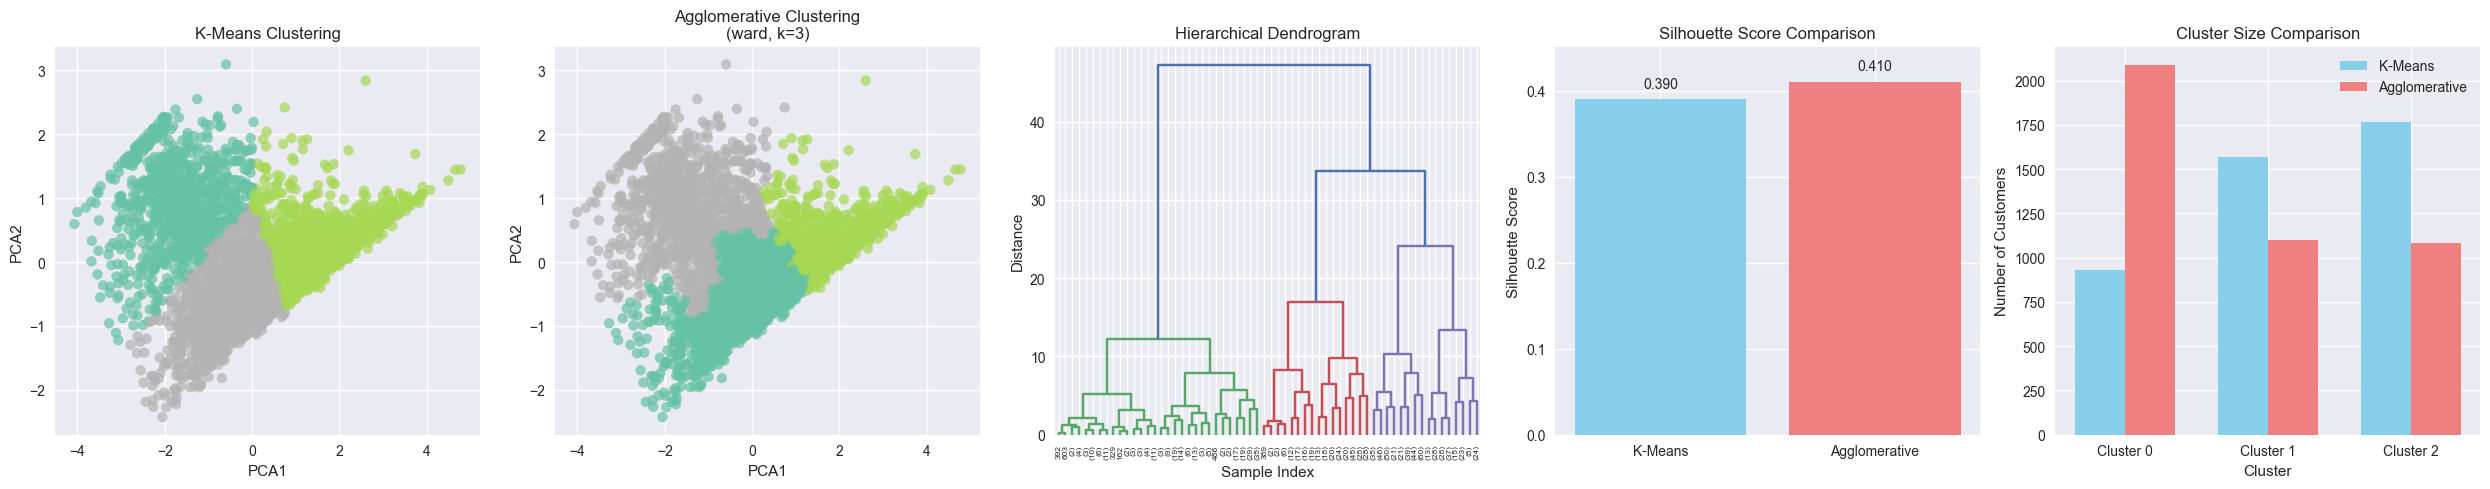

In [108]:
from scipy.cluster.hierarchy import dendrogram, linkage


print(f"- K-Means Silhouette: {final_silhouette:.3f}")
print(f"- Agglomerative Silhouette: {agglo_silhouette:.3f}")

# --- K-Means cluster profiles ---
kmeans_profiles = rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean().round(2)
print("K-Means Cluster Profiles (mean RFM values):")
print(kmeans_profiles)

# --- Agglomerative cluster profiles ---
agglo_profiles = rfm.groupby('Agglo_Cluster')[['Recency','Frequency','Monetary']].mean().round(2)
print("\nAgglomerative Cluster Profiles (mean RFM values):")
print(agglo_profiles)
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
(ax1, ax2, ax3, ax4, ax5) = axes.flatten()

# K-Means results
ax1.scatter(rfm['PCA1'], rfm['PCA2'], c=rfm['Cluster'], cmap='Set2', alpha=0.7, s=50)
ax1.set_title('K-Means Clustering')
ax1.set_xlabel('PCA1')
ax1.set_ylabel('PCA2')

# Agglomerative results
ax2.scatter(rfm['PCA1'], rfm['PCA2'], c=rfm['Agglo_Cluster'], cmap='Set2', alpha=0.7, s=50)
ax2.set_title(f'Agglomerative Clustering\n({linkage_method}, k={n_clusters})')
ax2.set_xlabel('PCA1')
ax2.set_ylabel('PCA2')

# Dendrogram
sample_data = X_scaled if len(rfm) <= 1000 else X_scaled[np.random.choice(len(rfm), 1000, replace=False)]
linkage_matrix = linkage(sample_data, method='ward')
dendrogram(linkage_matrix, truncate_mode='level', p=5, ax=ax3)
ax3.set_title('Hierarchical Dendrogram')
ax3.set_xlabel('Sample Index')
ax3.set_ylabel('Distance')

# Silhouette comparison
methods = ['K-Means', 'Agglomerative']
silhouette_scores = [final_silhouette, agglo_silhouette]
bars = ax4.bar(methods, silhouette_scores, color=['skyblue', 'lightcoral'])
ax4.set_title('Silhouette Score Comparison')
ax4.set_ylabel('Silhouette Score')
ax4.set_ylim(0, max(silhouette_scores) * 1.1)
for bar, score in zip(bars, silhouette_scores):
    ax4.text(bar.get_x() + bar.get_width()/2., score + 0.01, f'{score:.3f}', ha='center', va='bottom')

# Cluster size comparison
cluster_sizes_kmeans = rfm['Cluster'].value_counts().sort_index()
cluster_sizes_agglo = rfm['Agglo_Cluster'].value_counts().sort_index()
x = np.arange(len(cluster_sizes_kmeans))
width = 0.35
ax5.bar(x - width/2, cluster_sizes_kmeans.values, width, label='K-Means', color='skyblue')
ax5.bar(x + width/2, cluster_sizes_agglo.values, width, label='Agglomerative', color='lightcoral')
ax5.set_title('Cluster Size Comparison')
ax5.set_xlabel('Cluster')
ax5.set_ylabel('Number of Customers')
ax5.set_xticks(x)
ax5.set_xticklabels([f'Cluster {i}' for i in range(n_clusters)])
ax5.legend()

plt.tight_layout()
plt.show()


## Recommend System

I also implemented a **Collaborative Filtering (CF) recommendation system** on the Online Retail dataset using both **user-based** and **item-based** approaches.  
- The customer-product matrix contained **4312 customers** and **4444 products**, with a **sparsity of 98.5%**.  
- **User-CF** recommendations were generated by finding similar customers based on purchase history.  
- **Item-CF** recommendations were generated by identifying items similar to those already purchased by the customer.  
- Sample results for a customer (ID: 12346) showed that both methods successfully suggested relevant products, including mugs, doormats, and novelty items.

---

## Discussion

- **User-CF** captures the tastes of similar customers, making it effective for discovering new products not previously bought by the target customer.  
- **Item-CF** focuses on product similarity and tends to recommend items closely related to the customer's existing purchases, which can reinforce existing preferences.  
- High sparsity (98.5%) is a challenge, as many customers have purchased only a few items, potentially reducing recommendation accuracy.  
- Both methods complement each other: User-CF introduces diversity, while Item-CF strengthens relevance.  

---

## Conclusion

- Collaborative Filtering is effective for e-commerce recommendation tasks, even on sparse datasets.  
- User-CF and Item-CF provide complementary insights: User-CF explores peer behavior, Item-CF leverages product similarity.  
- Overall, this experiment confirms that CF can generate meaningful recommendations to enhance customer experience and increase potential sales.


In [116]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

# Create customer-product matrix
customer_product_matrix = df_clean.pivot_table(
    index='Customer ID',
    columns='Description',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)

print(f"Customer-Product Matrix Shape: {customer_product_matrix.shape}")
sparsity = (customer_product_matrix == 0).sum().sum() / (customer_product_matrix.shape[0] * customer_product_matrix.shape[1]) * 100
print(f"Sparsity: {sparsity:.1f}%\n")


class CFRecommendationSystem:
    """Collaborative Filtering Recommendation System"""
    
    def __init__(self, customer_product_matrix: pd.DataFrame):
        self.customer_product_matrix = customer_product_matrix
        self.customer_similarity = None
        self.product_similarity = None
        
    def compute_similarities(self):
        """Compute cosine similarity matrices for customers and products."""
        self.customer_similarity = cosine_similarity(self.customer_product_matrix)
        self.product_similarity = cosine_similarity(self.customer_product_matrix.T)
    
    def user_cf_recommendations(self, customer_id: int, n_recommendations: int = 10) -> list:
        """Generate User-based CF recommendations for a given customer."""
        if customer_id not in self.customer_product_matrix.index:
            return []
        
        customer_idx = self.customer_product_matrix.index.get_loc(customer_id)
        similarities = self.customer_similarity[customer_idx]
        
        # Get top 50 similar customers excluding self
        similar_customers_idx = similarities.argsort()[-50:][::-1][1:]
        weights = similarities[similar_customers_idx]
        
        similar_customers_purchases = self.customer_product_matrix.iloc[similar_customers_idx]
        scores = (similar_customers_purchases.T * weights).sum(axis=1) / weights.sum()
        
        # Remove already purchased items
        customer_purchases = self.customer_product_matrix.loc[customer_id]
        scores = scores[customer_purchases == 0]
        
        return scores.nlargest(n_recommendations).index.tolist()
    
    def item_cf_recommendations(self, customer_id: int, n_recommendations: int = 10) -> list:
        """Generate Item-based CF recommendations for a given customer."""
        if customer_id not in self.customer_product_matrix.index:
            return []
        
        customer_purchases = self.customer_product_matrix.loc[customer_id]
        purchased_items = customer_purchases[customer_purchases > 0].index
        
        if len(purchased_items) == 0:
            return []
        
        scores = pd.Series(0.0, index=self.customer_product_matrix.columns)
        for item in purchased_items:
            item_idx = self.customer_product_matrix.columns.get_loc(item)
            scores += self.product_similarity[item_idx] * customer_purchases[item]
        
        # Remove already purchased items
        scores = scores[customer_purchases == 0]
        
        return scores.nlargest(n_recommendations).index.tolist()


# Initialize and compute similarities
cf_system = CFRecommendationSystem(customer_product_matrix)
cf_system.compute_similarities()

# Generate recommendations for sample customers
print("Generating recommendations for sample customers...\n")
sample_customers = customer_product_matrix.index[:1]

for customer_id in sample_customers:
    print(f"--- Customer {customer_id} ---")
    
    # Already purchased items
    purchased_items = customer_product_matrix.loc[customer_id]
    purchased_items = purchased_items[purchased_items > 0].index.tolist()
    
    print("Already Purchased Items:")
    for i, product in enumerate(purchased_items[:10], 1):
        print(f"  {i}. {product[:50]}...")
    if len(purchased_items) > 10:
        print(f"  ... and {len(purchased_items) - 10} more")
    
    # Recommendations
    user_recs = cf_system.user_cf_recommendations(customer_id, 10)
    item_recs = cf_system.item_cf_recommendations(customer_id, 10)
    
    print("\nUser-CF Recommendations:")
    for i, product in enumerate(user_recs, 1):
        print(f"  {i}. {product[:50]}...")
    
    print("\nItem-CF Recommendations:")
    for i, product in enumerate(item_recs, 1):
        print(f"  {i}. {product[:50]}...")
    print("\n" + "-"*50 + "\n")

Customer-Product Matrix Shape: (4312, 4444)
Sparsity: 98.5%

Generating recommendations for sample customers...

--- Customer 12346 ---
Already Purchased Items:
  1. DOORMAT 3 SMILEY CATS...
  2. DOORMAT AIRMAIL ...
  3. DOORMAT BLACK FLOCK ...
  4. DOORMAT CHRISTMAS VILLAGE...
  5. DOORMAT FAIRY CAKE...
  6. DOORMAT FANCY FONT HOME SWEET HOME...
  7. DOORMAT HOME SWEET HOME BLUE ...
  8. DOORMAT I LOVE LONDON...
  9. DOORMAT MERRY CHRISTMAS RED ...
  10. DOORMAT NEW ENGLAND...
  ... and 15 more

User-CF Recommendations:
  1. BLACK HEART CARD HOLDER...
  2. CREAM HEART CARD HOLDER...
  3. HOME SWEET HOME MUG...
  4. WOOD BLACK BOARD ANT WHITE FINISH...
  5. VINTAGE UNION JACK MEMOBOARD...
  6. GLAMOROUS  MUG...
  7. VINTAGE BILLBOARD TEA MUG...
  8. BLACK/BLUE DOTS RUFFLED UMBRELLA...
  9. RED/WHITE DOTS RUFFLED UMBRELLA...
  10. VINTAGE RED TEATIME MUG...

Item-CF Recommendations:
  1. DOORMAT TOPIARY...
  2. DOOR MAT SPOTTY HOME SWEET HOME...
  3. GLAMOROUS  MUG...
  4. DOORMAT ENGLI

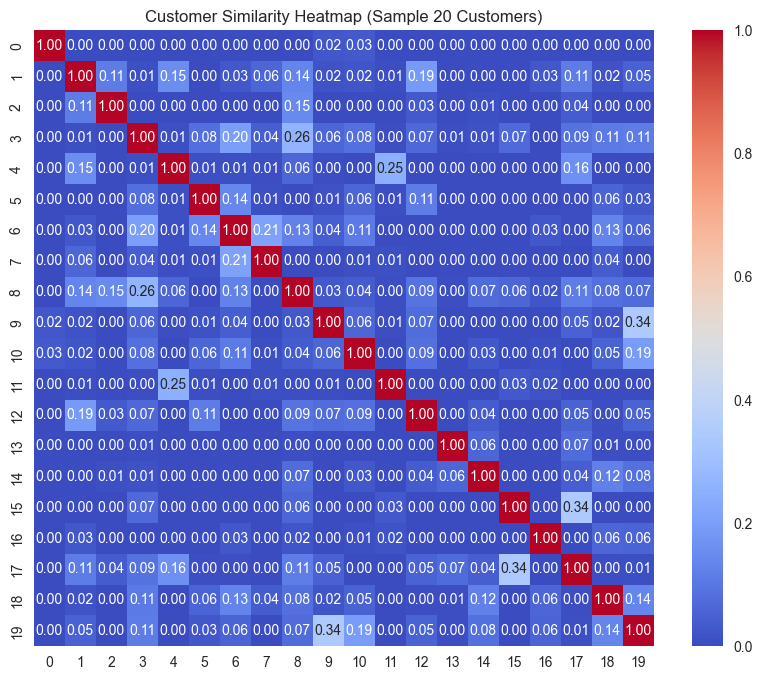

In [117]:
sample_idx = list(range(20))
plt.figure(figsize=(10, 8))
sns.heatmap(cf_system.customer_similarity[np.ix_(sample_idx, sample_idx)],
            cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Customer Similarity Heatmap (Sample 20 Customers)")
plt.show()


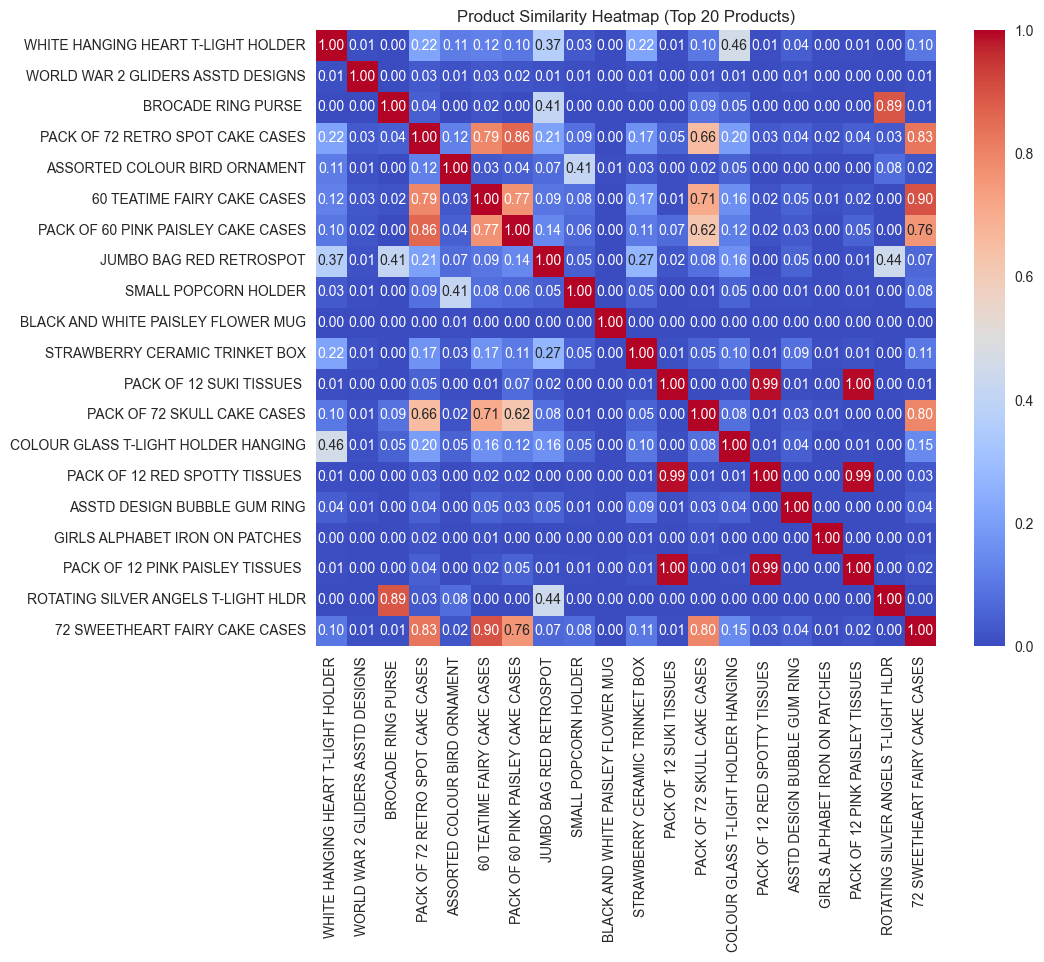

In [118]:
top_products = customer_product_matrix.sum().sort_values(ascending=False).index[:20]
product_idx = [customer_product_matrix.columns.get_loc(p) for p in top_products]

plt.figure(figsize=(10, 8))
sns.heatmap(cf_system.product_similarity[np.ix_(product_idx, product_idx)],
            xticklabels=top_products, yticklabels=top_products,
            cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Product Similarity Heatmap (Top 20 Products)")
plt.show()


# NMF-Based Purchase Prediction: Online Retail

## Introduction
I implement a **Collaborative Filtering system using Non-Negative Matrix Factorization (NMF)**, inspired by https://www.jstage.jst.go.jp/article/ipsjjip/27/0/27_752/_pdf.  
- Goal: Predict future product purchases from transactional data to enhance personalized recommendations.  
- Dataset: Online retail transactions with customers, products, and timestamps.

## Methodology
- **Data Preparation:** Transactions aggregated into a 3D tensor `(products × customers × months)`; log-transform applied to handle purchase frequency variations.  
- **NMF:** Decomposed average customer-product matrix into latent factors (`U`, `V`) capturing hidden patterns.  
- **Forecasting:** Linear projection of latent factors to predict future interactions.  
- **Prediction:** Threshold applied to generate binary predictions of likely purchases.

## Discussion
- **Advantages:** NMF captures latent structures; forecasting models temporal changes in customer preferences.  
- **Challenges:** High sparsity limits accuracy; threshold selection affects precision and recall.  
- **Insights:** User-product patterns and latent factors help identify relevant future purchases.

## Conclusion
- NMF with temporal forecasting effectively predicts potential purchases in sparse retail datasets.  
- The approach balances **relevance and diversity**, supporting personalized marketing and inventory planning.  
- Future improvements could include non-linear forecasting or hybrid NMF models.


### NMF Latent Factors & Forecast Summary

- **Uinit (Product Latent Factors)**
  - Shape: `(num_products, K)` → `(products × latent factors)`
  - Each row represents a product; each column represents a latent factor.
  - Value indicates how strongly a product belongs to a hidden pattern (e.g., home décor, kitchenware).

- **Vinit (Customer Latent Factors)**
  - Shape: `(K, num_customers)` → `(latent factors × customers)`
  - Each column represents a customer; each row represents a latent factor.
  - Value indicates how strongly a customer prefers each latent factor.

- **Linear Forecast**
  - Latent factors are forecasted over time to capture trends:
    - `U_forecast` → predicted product factors over T months
    - `V_forecast` → predicted customer factors over T months
  - Forecast uses a **linear regression per element** in the latent factor matrices, ensuring non-negative predictions.

- **Reconstruction**
  - `X_pred = U_forecast @ V_forecast` → shape `(num_products, num_customers)`
  - Each element predicts the likelihood of a customer purchasing a product in the future.


In [110]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF

# --- Prepare data ---
# Convert InvoiceDate to datetime and extract month for temporal aggregation
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
df_clean['Month'] = df_clean['InvoiceDate'].dt.to_period('M')

# Extract unique customers, products, and months
customers = df_clean['Customer ID'].unique()
products = df_clean['StockCode'].unique()
months = df_clean['Month'].sort_values().unique()
T = len(months)  # number of time periods

# Map customers, products, months to indices for tensor construction
customer_to_idx = {c: i for i, c in enumerate(customers)}
product_to_idx = {p: i for i, p in enumerate(products)}
month_to_idx = {m: i for i, m in enumerate(months)}

df_clean['CustomerIdx'] = df_clean['Customer ID'].map(customer_to_idx)
df_clean['ProductIdx'] = df_clean['StockCode'].map(product_to_idx)
df_clean['MonthIdx'] = df_clean['Month'].map(month_to_idx)

# --- Create 3D tensor: products x customers x months ---
Z = np.zeros((len(products), len(customers), T), dtype=np.float32)
indices = df_clean[['ProductIdx','CustomerIdx','MonthIdx']].values
quantities = df_clean['Quantity'].values
Z[indices[:,0], indices[:,1], indices[:,2]] = quantities  # fill tensor with purchase quantities

# Log-transform positive quantities to reduce skew and normalize data
Z = np.where(Z > 0, 1 + np.log(Z), 0)

# --- NMF on average matrix ---
XAve = Z.mean(axis=2)  # average over time to get a static product-customer matrix
K = 15  # number of latent factors
nmf_model = NMF(n_components=K, init='nndsvda', random_state=42, max_iter=500)
Uinit = nmf_model.fit_transform(XAve)  # customer latent factors
Vinit = nmf_model.components_          # product latent factors

# --- Forecast latent factors (vectorized) ---
def linear_forecast(matrix_seq):
    """
    Forecast future latent factors for each element of a matrix sequence.
    Args:
        matrix_seq: shape (T, dim1, dim2)
    Returns:
        forecast: matrix of shape (dim1, dim2)
    """
    T, dim1, dim2 = matrix_seq.shape
    x = np.arange(T)
    forecast = np.zeros((dim1, dim2), dtype=np.float32)
    
    # Fit a linear trend for each element independently
    for i in range(dim1):
        for j in range(dim2):
            y = matrix_seq[:, i, j]
            mask = y != 0  # only use non-zero values
            if mask.sum() > 1:
                coeff = np.polyfit(x[mask], y[mask], 1)  # linear regression
                forecast[i, j] = coeff[0]*T + coeff[1]   # forecast next step
            elif mask.sum() == 1:
                forecast[i, j] = y[mask][0]              # single observation
    return np.maximum(forecast, 0)  # ensure non-negative

# Forecast latent factors over T months
U_forecast = linear_forecast(np.broadcast_to(Uinit, (T, *Uinit.shape)))
V_forecast = linear_forecast(np.broadcast_to(Vinit, (T, *Vinit.shape)))

# --- Predict future purchase scores ---
X_pred = U_forecast @ V_forecast  # matrix multiplication of latent factors
threshold = 0.8
X_pred_binary = (X_pred > threshold).astype(np.int8)  # binarize predictions

# --- Convert predicted matrix to DataFrame ---
prod_idx, cust_idx = np.nonzero(X_pred_binary)  # indices of predicted purchases
df_pred = pd.DataFrame({
    'CustomerID': customers[cust_idx],
    'ProductID': products[prod_idx],
    'Predicted': 1
})

print(df_pred.shape)
print(df_pred.head(5))


(2995, 3)
   CustomerID ProductID  Predicted
0       15061    79323P          1
1       17865     21232          1
2       15311     21232          1
3       14911     21232          1
4       14040     21232          1


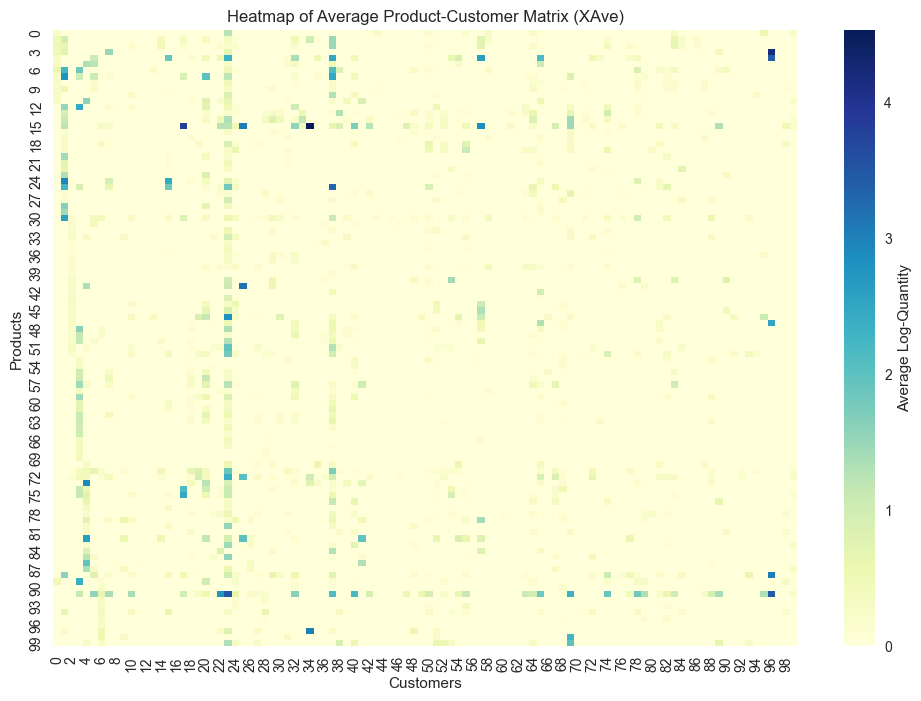

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns

sample_customers = 100
sample_products = 100
XAve_sample = XAve[:sample_products, :sample_customers]

plt.figure(figsize=(12, 8))
sns.heatmap(XAve_sample, cmap='YlGnBu', cbar_kws={'label': 'Average Log-Quantity'})
plt.xlabel('Customers')
plt.ylabel('Products')
plt.title('Heatmap of Average Product-Customer Matrix (XAve)')
plt.show()


### Predicted Customer-Product Heatmap

- Visualizes predicted purchases (Customers × Products).  

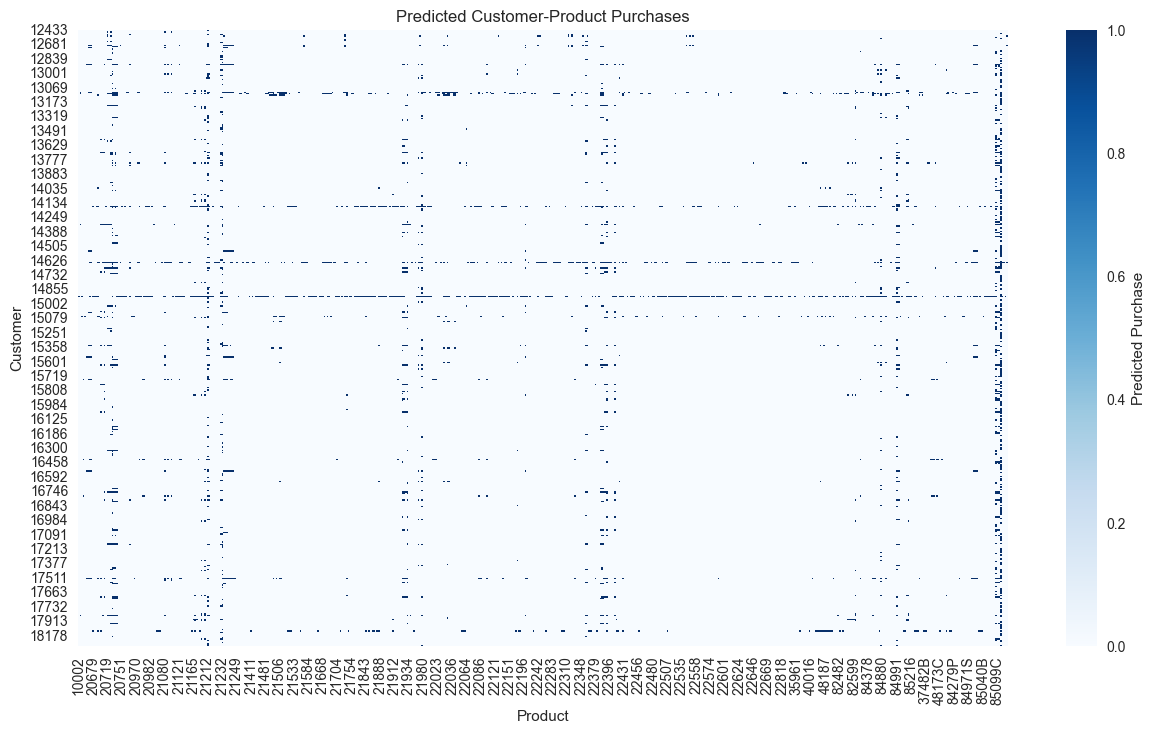

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

df_heat = df_pred.pivot(index='CustomerID', columns='ProductID', values='Predicted').fillna(0)

plt.figure(figsize=(15,8))
sns.heatmap(df_heat, cmap='Blues', cbar_kws={'label':'Predicted Purchase'})
plt.title("Predicted Customer-Product Purchases")
plt.xlabel("Product")
plt.ylabel("Customer")
plt.show()


### Predicted Products for Customer 14911

In [112]:
customer_14911_pred = df_pred[df_pred['CustomerID'] == 14911]
print(customer_14911_pred)


      CustomerID ProductID  Predicted
3          14911     21232          1
95         14911     21871          1
98         14911     21523          1
100        14911     22195          1
104        14911     21754          1
...          ...       ...        ...
2985       14911     22818          1
2986       14911     22909          1
2988       14911     22952          1
2991       14911     22910          1
2994       14911     22632          1

[335 rows x 3 columns]


# reference
https://www.jstage.jst.go.jp/article/ipsjjip/27/0/27_752/_pdf